# Lab:  Iris Flower Classification using Decision Theory

In this exercise, we will use decision theory on a simple multi-variable classification problem.  In doing the exercise, you will learn to:

* Load a pre-installed dataset in the `sklearn` package.
* Estimate parameters of a multi-variable Gaussian from data
* Make multi-class predictions using linear and quadratic discriminants derived from the Gaussian parameters
* Evaluate the accuracy of the predictions on test data

For submission:
* Complete all sections labeled `#TODO`
* Run the notebook and print to PDF.  
* Submit the PDF in CCLE.  No other formats accepted.  Do not submit the jupyter notebook.
* You may also do the lab in any other language (e.g. R) of your choice.  But only submit a single PDF file.  No source code.

We load the following packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from sklearn import linear_model, datasets
import seaborn as sns
import itertools

matplotlib.rcParams.update({'font.size': 16})

## Loading and Visualizing the Data

In this lab, we will use the classic dataset [Iris flower dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set).  The problem is to estimate the type of iris ('setosa' 'versicolor' 'virginica') from four features of the Iris flower.  Since the data is widely-used in machine learning classes, it is included in the `sklearn` package in python.  You can download the data with following command:

In [2]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Set`X=data.data` and `y=data.target`.  The matrix `X[i,j]` will then be the value of feature `j` in sample `i` and `y[i]` will be the index of the class for sample `i`.  Also, print:
* Number of samples,
* Number of features per sample
* Number of classes

In [3]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In [4]:
iris["species"].unique() 

array(['setosa', 'versicolor', 'virginica'], dtype=object)

Print the feature and target names in `data.feature_names` and `data.target_names`

In [5]:
print(list(iris))

['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']


To visualize the data, create a *scatter* plot of two of the four features:  `(sepal length, petal length)`.  In a scatter plot, each point is plotted as some marker, say a small circle.  Different colors are used for different class labels.  You can create a scatter plot using the `plt.scatter()` command.  Make sure you label your axes using the `plt.xlabel()` and `plt.ylabel()` axes.

If you did the plot correctly, you should see that you can separate the points well even just using two features.

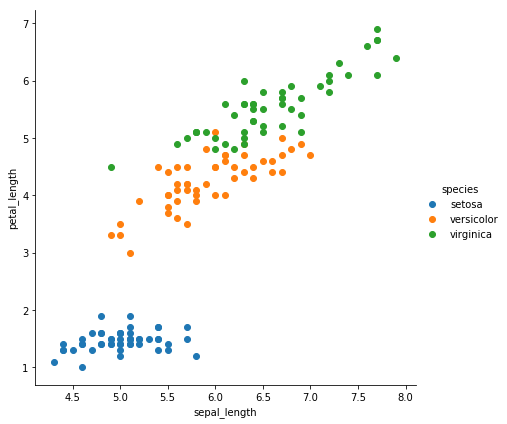

In [6]:
# TODO
sns.FacetGrid(iris, hue="species", 
              height=6).map(plt.scatter,"sepal_length", "petal_length").add_legend()


## Classifier Based on a Linear Discriminator

Before trying any classification methods, it is necessary to split the data into two components:
* Training samples:  Used for fitting the classifier models
* Test samples:  Used for testing the classifier

We will discuss splitting the training and test data in detail later in the class.  But, the reason for the splitting is that we want to test the classifier on samples not used in training.  This ensures we see how well it works on *new* samples that have not been seen.

For this purpose, divide the data into 75 samples `(Xtr,ytr)` for training and 75 samples `(Xts,yts)` for test.  You must randomly shuffle the samples before splitting -- do not pick the first 75 for training.  You can do the splitting manually or use the `sklearn.model_selection.train_test_split` function.  If you use `train_test_split()`, set `shuffle=True`.  

In [7]:
from sklearn.model_selection import train_test_split
np.random.seed(6) 

# TODO Split into training and test
Xtr, Xts, ytr, yts = train_test_split(iris[["sepal_length", "petal_length"]], 
                                      iris[["species"]], test_size=0.5, shuffle=True)

traindf = Xtr.copy()
traindf["species"] = ytr

testdf = Xts.copy()
testdf["species"] = yts

We will first try using a linear discriminator.  For linear discriminator we first need to estimate the sample mean of each class.  Complete the following function which returns:

    mu[:,j]  = sample mean of X[i,:]  for samples with y[i]=j

Run the function on the training data to get the sample means.

In [8]:
# TODO
mu = np.split(traindf.groupby('species').mean().values,[1,2])
mu

[array([[5.02 , 1.456]]), array([[6.036, 4.308]]), array([[6.644, 5.548]])]

Assuming a Gaussian model with equal and i.i.d. covariance matrices, the optimal estimator is given by the linear discrimantor:  Given a test sample `x`, we compute:

     g[j]  = mu[:,j].dot(x) - 0.5*sum(mu[:,j]**2)
     
    
for each class `j`.  Then, we select `yhat = argmax_j g[j]`.  Complete the following code which takes a matrix of data samples `X` to compute a vector of class predictions `yhat`.  

In [9]:
def predict_LDA(X,MU,SIGMA): 
    LDA_list = []
    
    def g(X, MU, SIGMA): 
        return (- 1/2 * (MU).T @ np.linalg.inv(SIGMA)@(MU) 
                + X.T @ np.linalg.inv(SIGMA)@ (MU)).flatten()[0]   
    
    for p in range(3):
        pred = g(X.reshape(-1,1), MU[p].reshape(-1,1), SIGMA) 
        LDA_list.append(pred)
    
    yhat = np.argmax(LDA_list)
    return yhat

Test the linear classifier on the test data.  Specifically, estimate `yhat` and measure the accuracy, which is the number of samples on which the classifier was correct.  If you did everything correctly, you should get an accuracy of around 90%.  But, it may be a little higher or lower depending on the random training / test split.   

In [10]:
test_y = testdf.iloc[:,2].replace({'setosa':0,'versicolor':1,'virginica':2}).copy()

#Classify and compute accuracy accuracy
y_hat = np.array([predict_LDA(np.array([xx,yy]).reshape(-1,1), mu, traindf.cov().values) 
                  for xx, yy in zip(np.ravel(testdf["sepal_length"]), 
                                    np.ravel(testdf["petal_length"]))] )

display(np.mean(y_hat == test_y))

0.8666666666666667

## Quadratic Discriminator

Now, we will try a more sophisticated classifier.  In this case, we will estimate both the sample mean and covariance matrix.  Complete the following code that computes:

* `mu`:  Array where `mu[:,j]` is the sample mean for the samples with `y[i]==j`.  This is identical to the code you have above.
* `S`:  Array of covariance matrices where `S[:,:,j]` is the sample covariance matrix for the samples with `y[i]==j`.  You can use the `np.cov()` method.

In [11]:
S = np.split(traindf.groupby('species').cov().values,[2,4], axis = 0)
S

[array([[0.0309    , 0.01508333],
        [0.01508333, 0.125     ]]), array([[0.2541 , 0.20095],
        [0.20095, 0.2774 ]]), array([[0.30093333, 0.32238333],
        [0.32238333, 0.45756667]])]

Given Gaussian models in each class the optimal decision rule is the following *quadratic* decision rule:  Given a sample `x`, we compute the discrimant,


    g[j] = 0.5*(x-mu[:,j).T.dot(Sinv[:,:,j]).dot(x-mu[:,j]) + 0.5*log(det(S[:,:,j]))
    

where `Sinv[:,:,j]` is the matrix inverse of `S[:,:,j]`.  Then, we take `yhat = argmin_j g[j]`.  Complete the following code to  compute the predictions based on the quadratic discriminats.

In [12]:
def predict_QDA(X, MU, SIGMA): 

    QDA_list = []
    
    def g(X, MU, SIGMA): 
        SIGMA_inv = np.linalg.inv(SIGMA)
        return (1/2 * np.log(np.linalg.det(SIGMA_inv)) 
                + 1/2 * (X - MU).T @ SIGMA_inv @ (X - MU)).flatten()[0]
    
    for p in range(3):
        pred = g(X.reshape(-1,1),MU[p].reshape(-1,1), SIGMA[p]) 
        QDA_list.append(pred)
    
    yhat = np.argmin(QDA_list)
    return yhat

Test the quadratic discriminator on the test data.  You should get around 98% accuracy depending on the train / test split.

In [13]:
y_hat = np.array([predict_QDA(np.array([xx,yy]).reshape(-1,1), mu, S) 
                  for xx, yy in zip(np.ravel(testdf["sepal_length"]), 
                                    np.ravel(testdf["petal_length"]))])

display(np.mean(y_hat == test_y))

0.9733333333333334